In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import time
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, Election
from gerrychain.updaters import cut_edges, Tally
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial

In [2]:
## Run ramdom walk on the shapefile './shapefiles/SC.geojson'
start_time = time.time()
sc_gdf = gpd.read_file("./shapefiles/SC.geojson")
sc_graph = Graph.from_geodataframe(sc_gdf)
print("Nodes info:", sc_graph.nodes()[0])

Nodes info: {'boundary_node': False, 'area': 9926699.65839994, 'COUNTY': '013', 'PCODE': '110', 'CODE_NAME': 'Burton 1A', 'G20PRER': 766, 'G20PRED': 625, 'G20USSR': 747, 'G20USSD': 647, 'TOTPOP': 3780, 'HISP': 524, 'NH_WHITE': 2033, 'NH_BLACK': 862, 'NH_AMIN': 13, 'NH_ASIAN': 108, 'NH_NHPI': 3, 'NH_OTHER': 29, 'NH_2MORE': 208, 'VAP': 2740, 'HVAP': 339, 'WVAP': 1534, 'BVAP': 636, 'AMINVAP': 10, 'ASIANVAP': 81, 'NHPIVAP': 2, 'OTHERVAP': 15, '2MOREVAP': 123, 'CD': '1', 'geometry': <POLYGON ((524841.421 3587457.977, 524851.164 3587434.168, 524853.92 3587422...>}


In [3]:
## Get the congressional district plan from the read-in data
initial_plan = {}
for node, data in sc_graph.nodes(data=True):
    if "CD" in data:
        initial_plan[node] = data["CD"]
print("Congressional District Plan:", initial_plan)

Congressional District Plan: {0: '1', 1: '1', 2: '1', 3: '1', 4: '1', 5: '1', 6: '1', 7: '1', 8: '1', 9: '1', 10: '1', 11: '1', 12: '1', 13: '1', 14: '1', 15: '1', 16: '1', 17: '1', 18: '1', 19: '1', 20: '1', 21: '1', 22: '1', 23: '1', 24: '1', 25: '1', 26: '1', 27: '1', 28: '1', 29: '1', 30: '1', 31: '1', 32: '1', 33: '1', 34: '1', 35: '1', 36: '1', 37: '1', 38: '1', 39: '1', 40: '1', 41: '1', 42: '1', 43: '1', 44: '1', 45: '1', 46: '1', 47: '1', 48: '1', 49: '1', 50: '1', 51: '1', 52: '1', 53: '1', 54: '1', 55: '1', 56: '1', 57: '1', 58: '1', 59: '1', 60: '1', 61: '1', 62: '1', 63: '1', 64: '1', 65: '1', 66: '1', 67: '1', 68: '1', 69: '1', 70: '1', 71: '1', 72: '1', 73: '1', 74: '1', 75: '1', 76: '1', 77: '1', 78: '1', 79: '1', 80: '1', 81: '1', 82: '1', 83: '1', 84: '1', 85: '1', 86: '1', 87: '1', 88: '1', 89: '1', 90: '1', 91: '1', 92: '1', 93: '2', 94: '2', 95: '2', 96: '2', 97: '2', 98: '2', 99: '2', 100: '2', 101: '2', 102: '2', 103: '2', 104: '2', 105: '2', 106: '2', 107: '2', 

In [4]:
initial_partition = Partition(
    sc_graph, 
    assignment=initial_plan,
    updaters={
        "our cut edges": cut_edges,
        "district population": Tally("TOTPOP", alias = "district population"), # across districts, add total population
        "district HISP": Tally("HISP", alias = "district HISP"),
        "votes for democrat - president election": Tally("G20PRED", alias = "votes for democrat - president election"),
        "votes for republic - president election": Tally("G20PRER", alias = "votes for republic - president election"),
        "votes for democrat - senate election": Tally("G20USSD", alias = "votes for democrat - senate election"),
        "votes for republic - senate election": Tally("G20USSR", alias = "votes for republic - senate election"),
        "PRES20": Election("PRES20", {"Democratic": "G20PRED", "Republican": "G20PRER"}), # President Election Updater
        "SEN20": Election("SEN20", {"Democratic": "G20USSD", "Republican": "G20USSR"}) # Senate Election Updater
    })

In [5]:
print("Initial Partition:", initial_partition)

Initial Partition: <Partition [7 parts]>


In [6]:
## Get the total populaton in South Carolina
tot_pop = sum([sc_graph.nodes()[v]["TOTPOP"] for v in sc_graph.nodes()])
print(tot_pop)

5118425


In [7]:
num_dist = len(initial_partition)
print("Number of districts:", num_dist)
ideal_pop = tot_pop / num_dist
pop_tolerance = 0.01

Number of districts: 7


In [8]:
proposal = partial(recom, ## How we choose a next districting plan
                   pop_col = "TOTPOP", ## The data describes population.
                   pop_target = ideal_pop, ## What the target/ideal population is for each district
                                          ## (we calculated ideal pop above)
                   epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                          ## (we set pop_tolerance above)
                   node_repeats = 1 ## number of times to repeat bipartition.
                  )

In [9]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition,
    pop_tolerance,
    pop_key="district population")

In [10]:
## Set up the random walk
our_random_walk = MarkovChain(
    proposal = proposal,
    constraints = [population_constraint],
    accept = always_accept, # Accept every proposed plan that meets the population constraints
    initial_state = initial_partition,
    total_steps = 100000)

In [11]:
cutedge_ensemble = [] ## list of number of cut-edges
lmaj_ensemble = []    ## list of number of majority-Latino districts in the plan
democratic_won_districts_ensemble_president_election = []  ## list of number of districts won by Democrat in president election
democratic_won_districts_ensemble_senate_election = []  ## list of number of districts won by Democrat in senate election
mean_median_difference_ensemble_president_election = []  ## list of mean median difference in president election
mean_median_difference_ensemble_senate_election = []  ## list of mean median difference in senate election
efficiency_gap_ensemble_president_election = [] ## list of efficient gap in president election
efficiency_gap_ ensemble_senate_election = [] ## list of efficient gap in president election
total_population = 0

In [12]:
## Run the random walk
for part in our_random_walk:
    # Add cutedges to cutedges ensemble
    cutedge_ensemble.append(len(part["our cut edges"]))

    # Calcuate the mean median difference and efficiency gap for the current partition in president election, and add to ensemble
    mean_median_difference_ensemble_president_election.append(part["PRES20"].mean_median())
    efficiency_gap_ensemble_president_election.append(part["PRES20"].efficiency_gap())

    # Calcuate the mean median difference and efficiency gap for the current partition in senate election, and add to ensemble
    mean_median_difference_ensemble_senate_election.append(part["SEN20"].mean_median())
    efficiency_gap_ensemble_senate_election.append(part["SEN20"].efficiency_gap())

    # Calculate number of Latino-majority districts, and add to ensemble
    num_maj_latino = 0
    # Calculate number of districts won by Democrat in the president election, and add to ensemble
    num_democrat_won_districts_president_election = 0
    # Calculate number of districts won by Democrat in the senate election, and add to ensemble
    num_democrat_won_districts_senate_election = 0
    total_population = 0
    for i in range(1, num_dist + 1):
        h_perc = part["district HISP"][str(i)] / part["district population"][str(i)]
        total_population += part["district population"][str(i)]
        if h_perc >= 0.5:
            num_maj_latino = num_maj_latino + 1
        if part["votes for democrat - president election"][str(i)] > part["votes for republic - president election"][str(i)]:
            num_democrat_won_districts_president_election += 1
        if part["votes for democrat - senate election"][str(i)] > part["votes for republic - senate election"][str(i)]:
            num_democrat_won_districts_senate_election += 1
    lmaj_ensemble.append(num_maj_latino)
    democratic_won_districts_ensemble_president_election.append(num_democrat_won_districts_president_election)
    democratic_won_districts_ensemble_senate_election.append(num_democrat_won_districts_senate_election)

In [13]:
print("Number of cut-edges:\n", cutedge_ensemble[:20])
print("Number of majority-Latino districts:\n", lmaj_ensemble[:20])
print("Number of districts won by Democrat in the president election:\n", democratic_won_districts_ensemble_senate_election[:20])
print("Number of districts won by Democrat in the senate election:\n", democratic_won_districts_ensemble_president_election[:20])
print("Mean Median Difference in the president election:\n", mean_median_difference_ensemble_president_election[:20])
print("Efficiency Gap in the president election:\n", efficiency_gap_ensemble_president_election[:20])
print("Mean Median Difference in the senate election:\n", mean_median_difference_ensemble_senate_election[:20])
print("Efficiency Gap in the senate election:\n", efficiency_gap_ensemble_senate_election[:20])
print("Total population in South Carolina:", total_population)

Number of cut-edges:
 [482, 516, 526, 472, 403, 405, 392, 437, 527, 531, 542, 549, 516, 453, 407, 417, 421, 417, 412, 414]
Number of majority-Latino districts:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of districts won by Democrat in the president election:
 [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3]
Number of districts won by Democrat in the senate election:
 [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2]
Mean Median Difference in the president election:
 [-0.03342961692725027, -0.03335179033678748, -0.023417256156443245, -0.021870139679880496, -0.021415283687740427, -0.021488593090869645, -0.02155328570156695, -0.02152425469774588, -0.02091781774515694, -0.0217113625418619, -0.021783880533305322, -0.021719494453666555, -0.02137376997411372, -0.021518658857699546, -0.021375675213882228, -0.0214740990252984, -0.021486372197263903, -0.021472590515897394, -0.014777208444123613, -0.014800060129247283]
Efficiency Gap in the preside

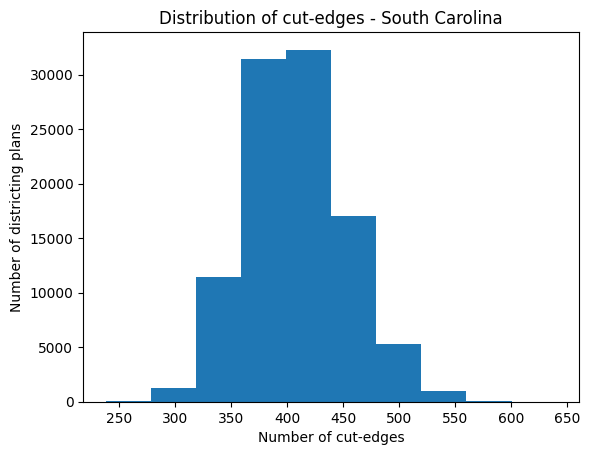

In [14]:
plt.figure()
plt.hist(cutedge_ensemble, align = 'left')
plt.xlabel('Number of cut-edges')
plt.ylabel('Number of districting plans')
plt.title('Distribution of cut-edges')
plt.title('Distribution of cut-edges - South Carolina')
plt.savefig('Distribution of cut-edges - South Carolina')
plt.show()

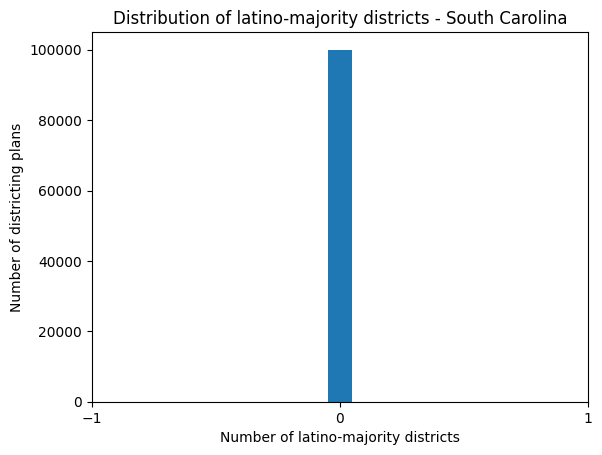

In [15]:
plt.figure()
plt.hist(lmaj_ensemble, align = 'left')
plt.xticks([-1, 0, 1])
plt.xlabel('Number of latino-majority districts')
plt.ylabel('Number of districting plans')
plt.title('Distribution of latino-majority districts - South Carolina')
plt.savefig('Distribution of latino-majority districts - South Carolina')
plt.show()

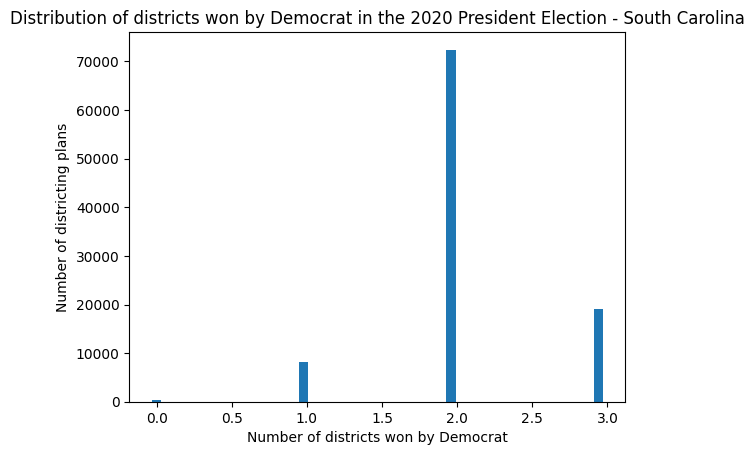

In [16]:
plt.figure()
bins = np.linspace(min(democratic_won_districts_ensemble_president_election), 
                       max(democratic_won_districts_ensemble_president_election))  # Adjust the number of bins as needed
plt.hist(democratic_won_districts_ensemble_president_election, bins = bins, align = 'left')
plt.xlabel('Number of districts won by Democrat')
plt.ylabel('Number of districting plans')
plt.title('Distribution of districts won by Democrat in the 2020 President Election - South Carolina')
plt.savefig('Distribution of districts won by Democrat in the 2020 President election - South Carolina')
plt.show()

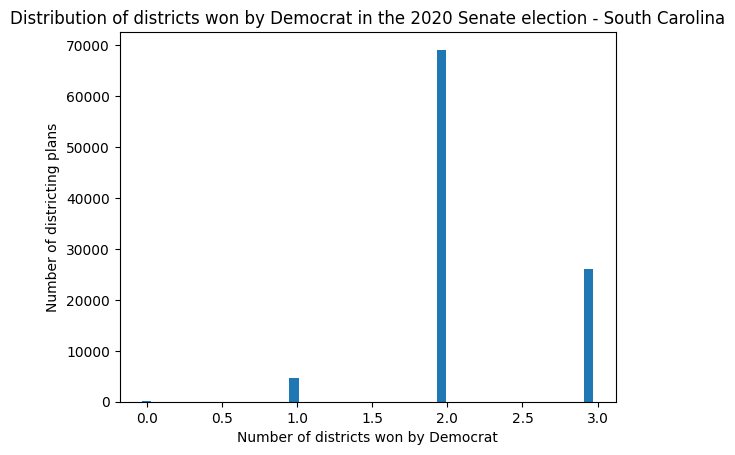

In [17]:
plt.figure()
bins = np.linspace(min(democratic_won_districts_ensemble_senate_election), 
                       max(democratic_won_districts_ensemble_senate_election))  # Adjust the number of bins as needed
plt.hist(democratic_won_districts_ensemble_senate_election, bins = bins, align = 'left')
plt.xlabel('Number of districts won by Democrat')
plt.ylabel('Number of districting plans')
plt.title('Distribution of districts won by Democrat in the 2020 Senate election - South Carolina')
plt.savefig('Distribution of districts won by Democrat in the 2020 Senate election - South Carolina')
plt.show()

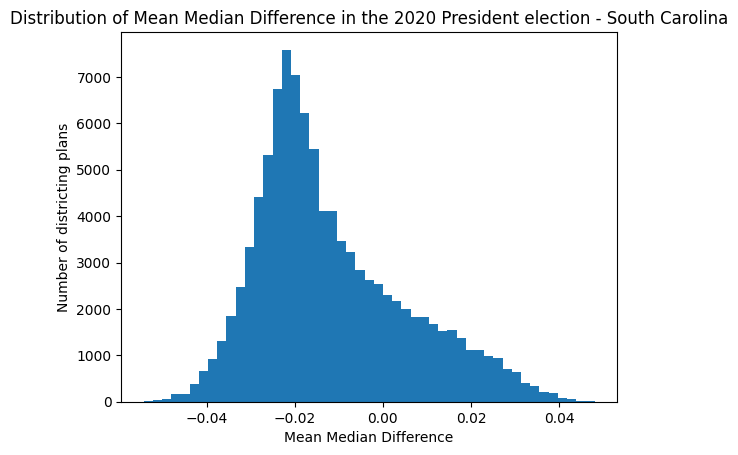

In [18]:
plt.figure()
bins = np.linspace(min(mean_median_difference_ensemble_president_election), 
                       max(mean_median_difference_ensemble_president_election))  # Adjust the number of bins as needed
plt.hist(mean_median_difference_ensemble_president_election, bins = bins, align = 'left')
plt.xlabel('Mean Median Difference')
plt.ylabel('Number of districting plans')
plt.title('Distribution of Mean Median Difference in the 2020 President election - South Carolina')
plt.savefig('Distribution of Mean Median Difference in the 2020 President election - South Carolina')
plt.show()

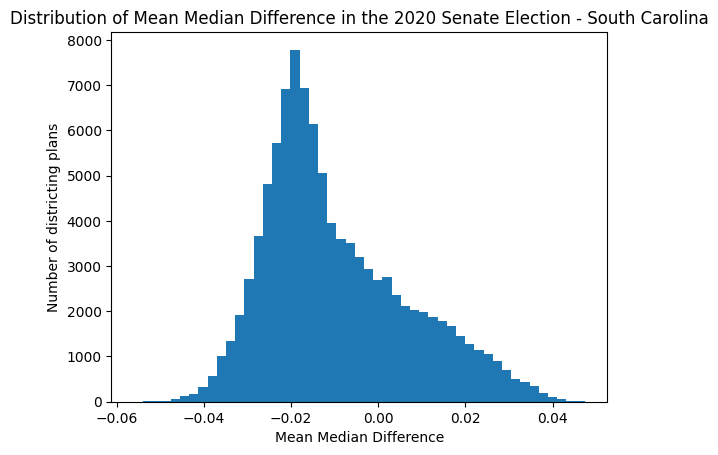

In [19]:
plt.figure()
bins = np.linspace(min(mean_median_difference_ensemble_senate_election), 
                       max(mean_median_difference_ensemble_senate_election))  # Adjust the number of bins as needed
plt.hist(mean_median_difference_ensemble_senate_election, bins = bins, align = 'left')
plt.xlabel('Mean Median Difference')
plt.ylabel('Number of districting plans')
plt.title('Distribution of Mean Median Difference in the 2020 Senate Election - South Carolina')
plt.savefig('Distribution of Mean Median Difference in the 2020 Senate election - South Carolina')
plt.show()

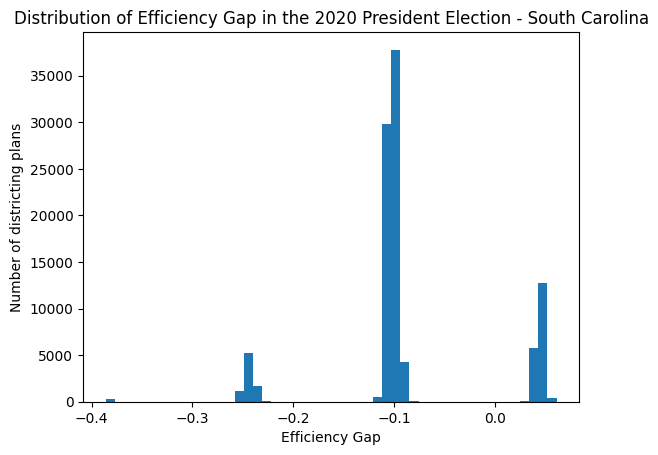

In [20]:
plt.figure()
bins = np.linspace(min(efficiency_gap_ensemble_president_election), 
                       max(efficiency_gap_ensemble_president_election))  # Adjust the number of bins as needed
plt.hist(efficiency_gap_ensemble_president_election, bins = bins, align = 'left')
plt.xlabel('Efficiency Gap')
plt.ylabel('Number of districting plans')
plt.title('Distribution of Efficiency Gap in the 2020 President Election - South Carolina')
plt.savefig('Distribution of Efficiency Gap in the 2020 President election - South Carolina')
plt.show()

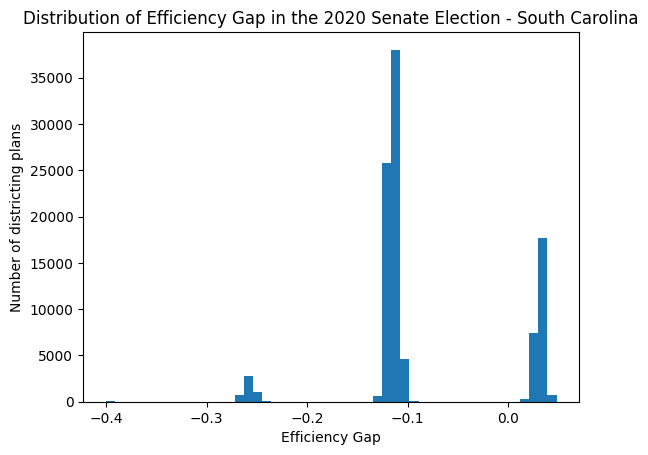

In [21]:
plt.figure()
bins = np.linspace(min(efficiency_gap_ensemble_senate_election), 
                       max(efficiency_gap_ensemble_senate_election))  # Adjust the number of bins as needed
plt.hist(efficiency_gap_ensemble_senate_election, bins = bins, align = 'left')
plt.xlabel('Efficiency Gap')
plt.ylabel('Number of districting plans')
plt.title('Distribution of Efficiency Gap in the 2020 Senate Election - South Carolina')
plt.savefig('Distribution of Efficiency Gap in the 2020 Senate election - South Carolina')
plt.show()

In [22]:
## Plot marginal box plot for the 2020 President eleciton and the 2020 Senate election
data_president_2020 = pd.DataFrame(
    sorted(partition["PRES20"].percents("Democratic"))
    for partition in our_random_walk.with_progress_bar()
)

/Users/ice/opt/anaconda3/envs/redisEnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [3:09:38<00:00,  8.79it/s]


In [23]:
data_senate_2020 = pd.DataFrame(
    sorted(partition["SEN20"].percents("Democratic"))
    for partition in our_random_walk.with_progress_bar()
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [3:07:22<00:00,  8.89it/s]


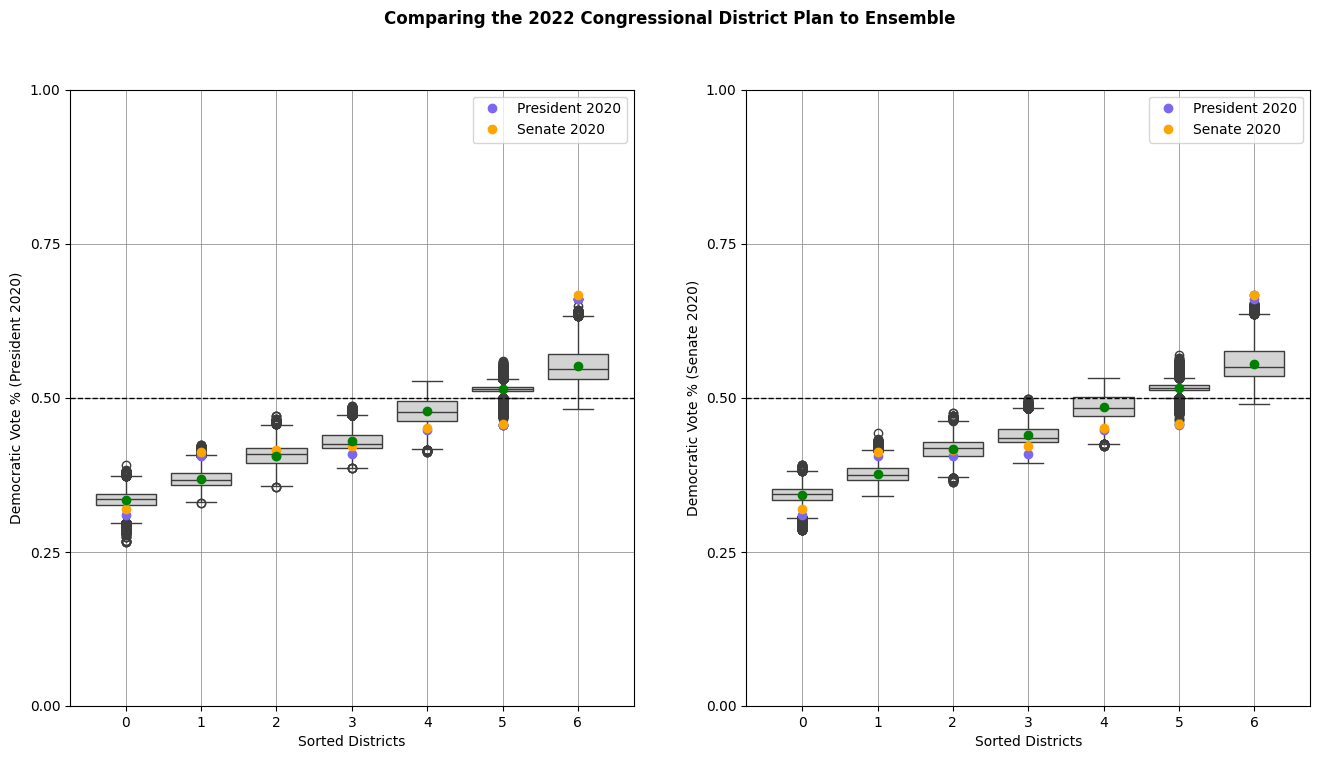

In [24]:
# Create a subplot with two columns for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# Draw the left plot
sns.boxplot(data=data_president_2020, ax=ax1, color='lightgray', showmeans=True, meanprops={"marker":"o", "markerfacecolor":"green", "markeredgecolor":"green"})

# Draw a horizontal line at 50%
ax1.axhline(0.5, color="black", linestyle='--', linewidth=1)  # Dashed line at 50%

# Plot the Democratic vote percentage for President 2020
ax1.plot(data_president_2020.iloc[0], "o", color="mediumslateblue", label='President 2020')

# Plot the Democratic vote percentage for Senate 2020
ax1.plot(data_senate_2020.iloc[0], "o", color="orange", label='Senate 2020')

ax1.set_ylabel("Democratic Vote % (President 2020)", fontsize=10)
ax1.set_xlabel("Sorted Districts", fontsize=10)

ax1.set_ylim(0, 1)
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')  # Add gridlines

ax1.legend()

# Draw the right plot
sns.boxplot(data=data_senate_2020, ax=ax2, color='lightgray', showmeans=True, meanprops={"marker":"o", "markerfacecolor":"g", "markeredgecolor":"g"})

# Draw a horizontal line at 50%
ax2.axhline(0.5, color="black", linestyle='--', linewidth=1)  # Dashed line at 50%

# Plot the Democratic vote percentage for President 2020
ax2.plot(data_president_2020.iloc[0], "o", color="mediumslateblue", label='President 2020')

# Plot the Democratic vote percentage for Senate 2020
ax2.plot(data_senate_2020.iloc[0], "o", color="orange", label='Senate 2020')

ax2.set_ylabel("Democratic Vote % (Senate 2020)", fontsize=10)
ax2.set_xlabel("Sorted Districts", fontsize=10)

ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax2.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')  # Add gridlines

ax2.legend()

plt.suptitle("Comparing the 2022 Congressional District Plan to Ensemble", fontsize=12, weight='bold')
plt.savefig('Signature of Gerrymandering - South Carolina')
plt.show()

In [25]:
end_time = time.time()
print("The time of execution of random walk of 100000 steps on South Carolina and drawing data analysis plots is:", (end_time-start_time)/60, "mins")

The time of execution of random walk of 100000 steps on South Carolina is : 558.0560854474703 mins
